## Dublin Bike Pre Processing data 

In [1]:
#import necessary libraries and files 
import pandas as pd
import numpy as np
import warnings
import time
import datetime as dt
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import folium
import sklearn
import seaborn as sns

from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans


%matplotlib inline

In [2]:
data1 = pd.read_csv('dublinbikes_20190401_20190701.csv')
data2 = pd.read_csv('dublinbikes_20190701_20191001.csv')
data3 = pd.read_csv('dublinbikes_20191001_20200101.csv')
data4 = pd.read_csv('dublinbikes_20200101_20200401.csv')
data5 = pd.read_csv('dublinbikes_20180701_20181001.csv')
data6 = pd.read_csv('dublinbikes_20180701_20181001.csv')
data1.sample(5)

,STATION ID,TIME,LAST UPDATED,NAME,BIKE STANDS,AVAILABLE BIKE STANDS,AVAILABLE BIKES,STATUS,ADDRESS,LATITUDE,LONGITUDE
377306,70,2019-04-12 11:35:03,2019-04-12 11:30:36,BARROW STREET,28,1,27,Open,Barrow Street,53.341656,-6.236198
47985,57,2019-04-02 00:10:03,2019-04-02 00:02:56,GRATTAN STREET,23,19,4,Open,Grattan Street,53.339630,-6.243778
2028044,39,2019-06-02 23:55:02,2019-06-02 23:53:03,WILTON TERRACE,20,14,6,Open,Wilton Terrace,53.332382,-6.252717
2193262,49,2019-06-07 20:20:02,2019-06-07 20:12:09,GUILD STREET,40,25,15,Open,Guild Street,53.347931,-6.240928
1701820,37,2019-05-23 06:35:02,2019-05-23 06:29:16,ST. STEPHEN'S GREEN SOUTH,30,27,3,Open,St. Stephen's Green South,53.337494,-6.261990


In [6]:
#merge data into one table
data = pd.concat([data1,data2, data3,data4])
data = data[data['STATUS'] == 'Open']
data = data[(data['LAST UPDATED'] >= '2019-07-01') & (data['LAST UPDATED'] < '2020-04-01')]
data = data[(data['LAST UPDATED'] < '2019-12-01') | (data['LAST UPDATED'] >= '2020-02-01')]

#remove rows where no update actually occurs
data = data.drop(['TIME'], axis = 1)
data.drop_duplicates(keep= 'first',inplace=True)


#get date and time columns
data['DATETIME'] = [dt.datetime.strptime(d, "%Y-%m-%d %H:%M:%S") for d in data["LAST UPDATED"]]
data['LAST UPDATED'] = [dt.datetime.time(d) for d in data['DATETIME']] 
data['DATE'] = [dt.datetime.date(d) for d in data['DATETIME']] 
data['date_for_merge'] = data['DATETIME'].dt.round('H')

#create important features
data['OCCUPANCY_PCT'] =  data['AVAILABLE BIKES'] / data['BIKE STANDS']
data['FULL'] = np.where(data['OCCUPANCY_PCT'] == 0, 1,0 )
data['EMPTY'] = np.where(data['OCCUPANCY_PCT'] == 1, 1,0 )

### create time aggregates needed for clustering
# weekday/saturday/sunday
data['DAY_NUMBER'] = data.DATETIME.dt.dayofweek
data['DAY_TYPE'] = np.where(data['DAY_NUMBER'] <= 4, 'Weekday', (np.where(data['DAY_NUMBER'] == 5, 'Saturday', 'Sunday')))

def bin_time(x):
    if x.time() < dt.time(6):
        return "Overnight "
    elif x.time() < dt.time(11):
        return "6AM-10AM "
    elif x.time() < dt.time(16):
        return "11AM-3PM "
    elif x.time() < dt.time(20):
        return "4PM-7PM "
    elif x.time() <= dt.time(23):
        return "8PM-11PM "
    else:
        return "Overnight "


data["TIME_TYPE"] = data['DATETIME'].apply(bin_time)
data['HOUR'] = data['DATETIME'].dt.hour
data['MONTH'] = data['DATETIME'].dt.month
data['CLUSTER_GROUP'] = data['TIME_TYPE'] + data['DAY_TYPE']

data.sample(5)

,STATION ID,LAST UPDATED,NAME,BIKE STANDS,AVAILABLE BIKE STANDS,AVAILABLE BIKES,STATUS,ADDRESS,LATITUDE,LONGITUDE,...,date_for_merge,OCCUPANCY_PCT,FULL,EMPTY,DAY_NUMBER,DAY_TYPE,TIME_TYPE,HOUR,MONTH,CLUSTER_GROUP
2063293,45,05:48:18,DEVERELL PLACE,30,13,17,Open,Deverell Place,53.351463,-6.255265,...,2019-09-03 06:00:00,0.566667,0,0,1,Weekday,Overnight,5,9,Overnight Weekday
596431,59,07:51:30,DENMARK STREET GREAT,20,9,11,Open,Denmark Street Great,53.355610,-6.261397,...,2019-07-19 08:00:00,0.550000,0,0,4,Weekday,6AM-10AM,7,7,6AM-10AM Weekday
2761006,39,08:17:55,WILTON TERRACE,20,0,19,Open,Wilton Terrace,53.332382,-6.252717,...,2019-09-25 08:00:00,0.950000,0,0,2,Weekday,6AM-10AM,8,9,6AM-10AM Weekday
851020,106,21:49:49,RATHDOWN ROAD,40,31,9,Open,Rathdown Road,53.358929,-6.280337,...,2020-02-17 22:00:00,0.225000,0,0,0,Weekday,8PM-11PM,21,2,8PM-11PM Weekday
2248777,23,06:48:50,CUSTOM HOUSE,30,17,13,Open,Custom House,53.348278,-6.254662,...,2019-09-09 07:00:00,0.433333,0,0,0,Weekday,6AM-10AM,6,9,6AM-10AM Weekday


In [7]:
data.head()

,STATION ID,LAST UPDATED,NAME,BIKE STANDS,AVAILABLE BIKE STANDS,AVAILABLE BIKES,STATUS,ADDRESS,LATITUDE,LONGITUDE,...,date_for_merge,OCCUPANCY_PCT,FULL,EMPTY,DAY_NUMBER,DAY_TYPE,TIME_TYPE,HOUR,MONTH,CLUSTER_GROUP
1,2,00:02:22,BLESSINGTON STREET,20,18,2,Open,Blessington Street,53.35677,-6.26814,...,2019-07-01 00:00:00,0.1,0,0,0,Weekday,Overnight,0,7,Overnight Weekday
3,2,00:12:31,BLESSINGTON STREET,20,18,2,Open,Blessington Street,53.35677,-6.26814,...,2019-07-01 00:00:00,0.1,0,0,0,Weekday,Overnight,0,7,Overnight Weekday
5,2,00:22:41,BLESSINGTON STREET,20,18,2,Open,Blessington Street,53.35677,-6.26814,...,2019-07-01 00:00:00,0.1,0,0,0,Weekday,Overnight,0,7,Overnight Weekday
7,2,00:32:50,BLESSINGTON STREET,20,18,2,Open,Blessington Street,53.35677,-6.26814,...,2019-07-01 01:00:00,0.1,0,0,0,Weekday,Overnight,0,7,Overnight Weekday
9,2,00:42:59,BLESSINGTON STREET,20,18,2,Open,Blessington Street,53.35677,-6.26814,...,2019-07-01 01:00:00,0.1,0,0,0,Weekday,Overnight,0,7,Overnight Weekday


In [ ]:
#Selecting the stations 
#selected_stations = [68,78,83,85,88,97]

### Time cluster 

In [8]:
#group data into clusters
clustering_df = data[['STATION ID', 'NAME', 'LATITUDE', 'LONGITUDE', 'DAY_TYPE', 'TIME_TYPE', 'OCCUPANCY_PCT','CLUSTER_GROUP']]
clustering_df = clustering_df.groupby(['STATION ID', 'NAME', 'LATITUDE', 'LONGITUDE', 'CLUSTER_GROUP'],as_index=False)['OCCUPANCY_PCT'].mean()
clustering_df  = clustering_df.set_index('STATION ID')

#pivot dataframe for clustering
clustering_df = clustering_df.pivot_table(index= ['NAME', 'STATION ID','LATITUDE', 'LONGITUDE'] , columns=['CLUSTER_GROUP'], values='OCCUPANCY_PCT')
clustering_df  = clustering_df.reset_index()
clustering_df  = clustering_df .set_index('NAME')
clustering_df = clustering_df.dropna()

clustering_df.sample(5)

CLUSTER_GROUP,STATION ID,LATITUDE,LONGITUDE,11AM-3PM Saturday,11AM-3PM Sunday,11AM-3PM Weekday,4PM-7PM Saturday,4PM-7PM Sunday,4PM-7PM Weekday,6AM-10AM Saturday,6AM-10AM Sunday,6AM-10AM Weekday,8PM-11PM Saturday,8PM-11PM Sunday,8PM-11PM Weekday,Overnight Saturday,Overnight Sunday,Overnight Weekday
NAME,,,,,,,,,,,,,,,,,,
PARNELL SQUARE NORTH,30,53.353462,-6.265305,0.196933,0.181635,0.171745,0.246466,0.162468,0.123804,0.173413,0.177023,0.145463,0.173618,0.152057,0.146922,0.169034,0.173403,0.163088
MERRION SQUARE EAST,25,53.339436,-6.246548,0.221215,0.232488,0.760092,0.202044,0.212451,0.199842,0.175125,0.202071,0.624279,0.195529,0.216599,0.088516,0.124720,0.166697,0.087156
PEARSE STREET,32,53.344303,-6.250427,0.690190,0.719387,0.469630,0.509737,0.574579,0.634914,0.480496,0.478125,0.398489,0.391214,0.405622,0.245459,0.300589,0.347443,0.177740
ROYAL HOSPITAL,95,53.343899,-6.297060,0.232809,0.139708,0.089397,0.223799,0.190256,0.435634,0.468280,0.234689,0.230907,0.237725,0.263508,0.726957,0.547552,0.290544,0.739445
BENSON STREET,90,53.344154,-6.233451,0.178727,0.142477,0.655158,0.125685,0.142831,0.091801,0.225119,0.190721,0.735708,0.134686,0.166334,0.059702,0.093759,0.161444,0.109268


## K-means clustering analysis 

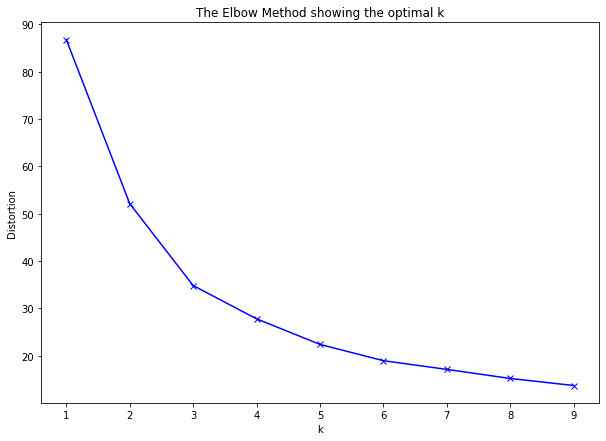

In [9]:
distortions = []
K = range(1,10)
X = np.array(clustering_df.drop(['STATION ID', 'LATITUDE', 'LONGITUDE'], 1).astype(float))
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(X)
    distortions.append(kmeanModel.inertia_)
    
plt.figure(figsize=(10,7))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [10]:
#clustering algo
X = np.array(clustering_df.drop(['STATION ID', 'LATITUDE', 'LONGITUDE'], 1).astype(float))
KM = KMeans(n_clusters=5) 
KM.fit(X)
clusters = KM.predict(X)

locations = clustering_df
locations['Cluster'] = clusters
locations = locations.reset_index()
locations.head(5)

CLUSTER_GROUP,NAME,STATION ID,LATITUDE,LONGITUDE,11AM-3PM Saturday,11AM-3PM Sunday,11AM-3PM Weekday,4PM-7PM Saturday,4PM-7PM Sunday,4PM-7PM Weekday,6AM-10AM Saturday,6AM-10AM Sunday,6AM-10AM Weekday,8PM-11PM Saturday,8PM-11PM Sunday,8PM-11PM Weekday,Overnight Saturday,Overnight Sunday,Overnight Weekday,Cluster
0,AVONDALE ROAD,108,53.359406,-6.276142,0.159102,0.126197,0.107060,0.208063,0.183721,0.247766,0.279970,0.168737,0.154918,0.206872,0.252699,0.369088,0.390925,0.243118,0.421789,4
1,BARROW STREET,70,53.341656,-6.236198,0.457221,0.129602,0.703599,0.091699,0.502551,0.163900,0.593277,0.249084,0.730308,0.119338,0.753040,0.218540,0.287356,0.247592,0.315751,1
2,BENSON STREET,90,53.344154,-6.233451,0.178727,0.142477,0.655158,0.125685,0.142831,0.091801,0.225119,0.190721,0.735708,0.134686,0.166334,0.059702,0.093759,0.161444,0.109268,1
3,BLACKHALL PLACE,88,53.348801,-6.281637,0.375960,0.442651,0.131210,0.439610,0.480735,0.409125,0.559444,0.566730,0.237267,0.556918,0.625755,0.760816,0.730187,0.657854,0.828303,0
4,BLESSINGTON STREET,2,53.356770,-6.268140,0.177049,0.079175,0.118073,0.170406,0.188239,0.248699,0.164333,0.129490,0.161376,0.206522,0.278690,0.482975,0.420940,0.282905,0.545053,4


In [11]:
colordict = {0: 'blue', 1: 'red', 2: 'orange', 3: 'green', 4: 'purple'}
dublin_map = folium.Map([53.345, -6.2650], zoom_start=13.5)
for LATITUDE, LONGITUDE, Cluster in zip(locations['LATITUDE'],locations['LONGITUDE'], locations['Cluster']):
    folium.CircleMarker(
        [LATITUDE, LONGITUDE],
        color = 'b',
        radius = 8,
        fill_color=colordict[Cluster],
        fill=True,
        fill_opacity=0.9
        ).add_to(dublin_map)
dublin_map
    

Based on the mat the location stations choosen were: 
- 'HANOVER QUAY' in Grand Canal Dock 
- 'FITZWILLIAM SQUARE EAST' in south Dublin 
- 'ST JAMES HOSPITAL (LUAS)'- south Dublin residential area 

In [12]:
#df.drop(columns=["ADDRESS","LATITUDE","LONGITUDE","LAST UPDATED","NAME","STATION ID","AVAILABLE BIKE STANDS","STATUS"],axis=1,inplace=True)
#df["TIME"]=pd.to_datetime(df["TIME"])  
#df.sort_values(by=['TIME'],inplace=True)
#df["GAP AMOUNT"]=df["TIME"].diff().dt.seconds/60

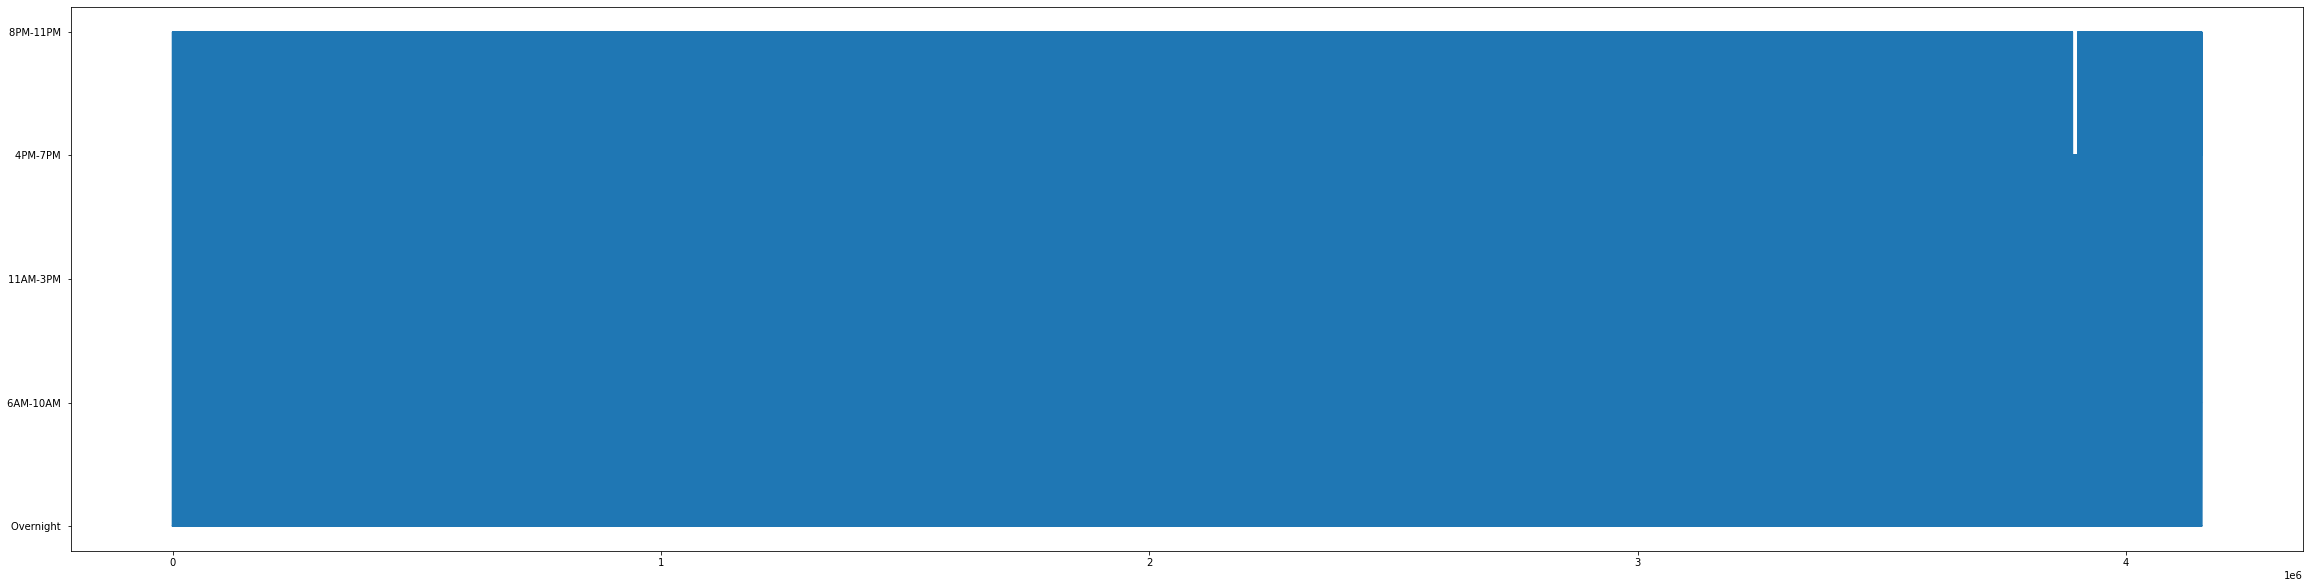

In [13]:
fig,ax = plt.subplots(1, 1, figsize=(40, 10))
ax.plot(range(0,len(data['AVAILABLE BIKES'])),data["TIME_TYPE"])
plt.show()

## Hanover mask for 28/2 + 31/3

In [51]:
# Creating a mask for Hanover Quay.
mask_hanover = data.NAME == 'HANOVER QUAY'
hanover_data = data[mask_hanover]
hanover_data

,STATION ID,LAST UPDATED,NAME,BIKE STANDS,AVAILABLE BIKE STANDS,AVAILABLE BIKES,STATUS,ADDRESS,LATITUDE,LONGITUDE,...,date_for_merge,OCCUPANCY_PCT,FULL,EMPTY,DAY_NUMBER,DAY_TYPE,TIME_TYPE,HOUR,MONTH,CLUSTER_GROUP
18434,68,00:09:01,HANOVER QUAY,40,23,16,Open,Hanover Quay,53.344116,-6.237153,...,2019-07-01 00:00:00,0.40,0,0,0,Weekday,Overnight,0,7,Overnight Weekday
18436,68,00:19:10,HANOVER QUAY,40,23,16,Open,Hanover Quay,53.344116,-6.237153,...,2019-07-01 00:00:00,0.40,0,0,0,Weekday,Overnight,0,7,Overnight Weekday
18439,68,00:29:20,HANOVER QUAY,40,23,16,Open,Hanover Quay,53.344116,-6.237153,...,2019-07-01 00:00:00,0.40,0,0,0,Weekday,Overnight,0,7,Overnight Weekday
18441,68,00:39:28,HANOVER QUAY,40,23,16,Open,Hanover Quay,53.344116,-6.237153,...,2019-07-01 01:00:00,0.40,0,0,0,Weekday,Overnight,0,7,Overnight Weekday
18443,68,00:49:37,HANOVER QUAY,40,23,16,Open,Hanover Quay,53.344116,-6.237153,...,2019-07-01 01:00:00,0.40,0,0,0,Weekday,Overnight,0,7,Overnight Weekday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2182766,68,23:15:42,HANOVER QUAY,40,24,14,Open,Hanover Quay,53.344116,-6.237153,...,2020-03-31 23:00:00,0.35,0,0,1,Weekday,Overnight,23,3,Overnight Weekday
2182768,68,23:25:51,HANOVER QUAY,40,24,14,Open,Hanover Quay,53.344116,-6.237153,...,2020-03-31 23:00:00,0.35,0,0,1,Weekday,Overnight,23,3,Overnight Weekday
2182769,68,23:32:40,HANOVER QUAY,40,24,14,Open,Hanover Quay,53.344116,-6.237153,...,2020-04-01 00:00:00,0.35,0,0,1,Weekday,Overnight,23,3,Overnight Weekday
2182771,68,23:42:48,HANOVER QUAY,40,24,14,Open,Hanover Quay,53.344116,-6.237153,...,2020-04-01 00:00:00,0.35,0,0,1,Weekday,Overnight,23,3,Overnight Weekday


In [52]:
hanover_dates = pd.to_datetime(hanover_data.date_for_merge, format = "%Y-%m-%d %H:%M:%S")

In [53]:
print(hanover_dates)

18434     2019-07-01 00:00:00
18436     2019-07-01 00:00:00
18439     2019-07-01 00:00:00
18441     2019-07-01 01:00:00
18443     2019-07-01 01:00:00
                  ...        
2182766   2020-03-31 23:00:00
2182768   2020-03-31 23:00:00
2182769   2020-04-01 00:00:00
2182771   2020-04-01 00:00:00
2182773   2020-04-01 00:00:00
Name: date_for_merge, Length: 42345, dtype: datetime64[ns]


In [54]:
hanover_dates.dt.date

18434      2019-07-01
18436      2019-07-01
18439      2019-07-01
18441      2019-07-01
18443      2019-07-01
              ...    
2182766    2020-03-31
2182768    2020-03-31
2182769    2020-04-01
2182771    2020-04-01
2182773    2020-04-01
Name: date_for_merge, Length: 42345, dtype: object

In [55]:
date_vector_h = pd.DatetimeIndex(hanover_dates.dt.date)
print(date_vector_h)

DatetimeIndex(['2019-07-01', '2019-07-01', '2019-07-01', '2019-07-01',
               '2019-07-01', '2019-07-01', '2019-07-01', '2019-07-01',
               '2019-07-01', '2019-07-01',
               ...
               '2020-03-31', '2020-03-31', '2020-03-31', '2020-03-31',
               '2020-03-31', '2020-03-31', '2020-03-31', '2020-04-01',
               '2020-04-01', '2020-04-01'],
              dtype='datetime64[ns]', name='date_for_merge', length=42345, freq=None)


In [56]:
Day_of_interest1 = '2020-03-31'
Day_index_h1 = date_vector_h == Day_of_interest1
print(Day_of_interest1)

2020-03-31


In [57]:
hanover_data[Day_index_h1]

,STATION ID,LAST UPDATED,NAME,BIKE STANDS,AVAILABLE BIKE STANDS,AVAILABLE BIKES,STATUS,ADDRESS,LATITUDE,LONGITUDE,...,date_for_merge,OCCUPANCY_PCT,FULL,EMPTY,DAY_NUMBER,DAY_TYPE,TIME_TYPE,HOUR,MONTH,CLUSTER_GROUP
2151089,68,23:32:50,HANOVER QUAY,40,23,17,Open,Hanover Quay,53.344116,-6.237153,...,2020-03-31 00:00:00,0.425,0,0,0,Weekday,Overnight,23,3,Overnight Weekday
2151091,68,23:42:59,HANOVER QUAY,40,23,17,Open,Hanover Quay,53.344116,-6.237153,...,2020-03-31 00:00:00,0.425,0,0,0,Weekday,Overnight,23,3,Overnight Weekday
2151093,68,23:53:09,HANOVER QUAY,40,23,17,Open,Hanover Quay,53.344116,-6.237153,...,2020-03-31 00:00:00,0.425,0,0,0,Weekday,Overnight,23,3,Overnight Weekday
2182487,68,00:03:58,HANOVER QUAY,40,23,17,Open,Hanover Quay,53.344116,-6.237153,...,2020-03-31 00:00:00,0.425,0,0,1,Weekday,Overnight,0,3,Overnight Weekday
2182490,68,00:15:04,HANOVER QUAY,40,23,17,Open,Hanover Quay,53.344116,-6.237153,...,2020-03-31 00:00:00,0.425,0,0,1,Weekday,Overnight,0,3,Overnight Weekday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2182760,68,22:45:15,HANOVER QUAY,40,24,14,Open,Hanover Quay,53.344116,-6.237153,...,2020-03-31 23:00:00,0.350,0,0,1,Weekday,8PM-11PM,22,3,8PM-11PM Weekday
2182762,68,22:55:24,HANOVER QUAY,40,24,14,Open,Hanover Quay,53.344116,-6.237153,...,2020-03-31 23:00:00,0.350,0,0,1,Weekday,8PM-11PM,22,3,8PM-11PM Weekday
2182764,68,23:05:33,HANOVER QUAY,40,24,14,Open,Hanover Quay,53.344116,-6.237153,...,2020-03-31 23:00:00,0.350,0,0,1,Weekday,Overnight,23,3,Overnight Weekday
2182766,68,23:15:42,HANOVER QUAY,40,24,14,Open,Hanover Quay,53.344116,-6.237153,...,2020-03-31 23:00:00,0.350,0,0,1,Weekday,Overnight,23,3,Overnight Weekday


In [58]:
hanover_day_of_interest1 = hanover_dates[Day_index_h1]
time_h1 = hanover_day_of_interest1.dt.hour
stands_h1 = hanover_data[Day_index_h1]['AVAILABLE BIKE STANDS']
bikes_h1 = hanover_data[Day_index_h1]['AVAILABLE BIKES']
bikes_h1

2151089    17
2151091    17
2151093    17
2182487    17
2182490    17
           ..
2182760    14
2182762    14
2182764    14
2182766    14
2182768    14
Name: AVAILABLE BIKES, Length: 154, dtype: int64

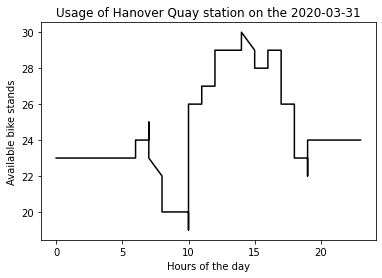

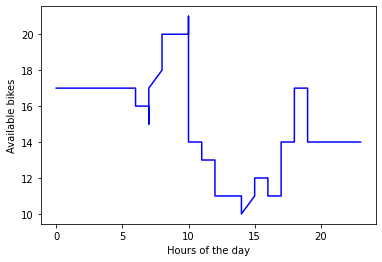

In [59]:
plt.figure()
plt.title(f'Usage of Hanover Quay station on the {Day_of_interest1}')
plt.plot(time_h1, stands_h1, 'k')
plt.xlabel('Hours of the day')
plt.ylabel('Available bike stands')
plt.title(f'Usage of Hanover Quay station on the {Day_of_interest1}')

plt.figure()
plt.plot(time_h1, bikes_h1, 'b')
plt.xlabel('Hours of the day')
plt.ylabel('Available bikes')
plt.show()

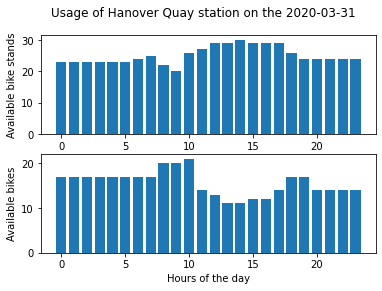

In [60]:
fig, (ax1, ax2) = plt.subplots(2)
fig.suptitle(f'Usage of Hanover Quay station on the {Day_of_interest1}')
ax1.bar(time_h1, stands_h1)
ax1.set_xlabel('Hours of the day')
ax1.set_ylabel('Available bike stands')
ax2.bar(time_h1, bikes_h1)
ax2.set_xlabel('Hours of the day')
ax2.set_ylabel('Available bikes')
plt.show()

Let's try for another day, before the lockdown order.
28 February, the day before the first case in Ireland.

In [61]:
Day_of_interest2 = '2020-02-28'
Day_index_h2 = date_vector_h == Day_of_interest2
print(Day_of_interest1)

2020-03-31


In [62]:
hanover_data[Day_index_h2]

,STATION ID,LAST UPDATED,NAME,BIKE STANDS,AVAILABLE BIKE STANDS,AVAILABLE BIKES,STATUS,ADDRESS,LATITUDE,LONGITUDE,...,date_for_merge,OCCUPANCY_PCT,FULL,EMPTY,DAY_NUMBER,DAY_TYPE,TIME_TYPE,HOUR,MONTH,CLUSTER_GROUP
1154305,68,23:34:11,HANOVER QUAY,40,39,1,Open,Hanover Quay,53.344116,-6.237153,...,2020-02-28 00:00:00,0.025,0,0,3,Weekday,Overnight,23,2,Overnight Weekday
1154307,68,23:44:19,HANOVER QUAY,40,39,1,Open,Hanover Quay,53.344116,-6.237153,...,2020-02-28 00:00:00,0.025,0,0,3,Weekday,Overnight,23,2,Overnight Weekday
1154309,68,23:50:40,HANOVER QUAY,40,40,0,Open,Hanover Quay,53.344116,-6.237153,...,2020-02-28 00:00:00,0.000,1,0,3,Weekday,Overnight,23,2,Overnight Weekday
1185557,68,00:00:48,HANOVER QUAY,40,40,0,Open,Hanover Quay,53.344116,-6.237153,...,2020-02-28 00:00:00,0.000,1,0,4,Weekday,Overnight,0,2,Overnight Weekday
1185559,68,00:11:27,HANOVER QUAY,40,39,1,Open,Hanover Quay,53.344116,-6.237153,...,2020-02-28 00:00:00,0.025,0,0,4,Weekday,Overnight,0,2,Overnight Weekday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1185830,68,22:45:15,HANOVER QUAY,40,40,0,Open,Hanover Quay,53.344116,-6.237153,...,2020-02-28 23:00:00,0.000,1,0,4,Weekday,8PM-11PM,22,2,8PM-11PM Weekday
1185832,68,22:55:24,HANOVER QUAY,40,40,0,Open,Hanover Quay,53.344116,-6.237153,...,2020-02-28 23:00:00,0.000,1,0,4,Weekday,8PM-11PM,22,2,8PM-11PM Weekday
1185834,68,23:05:32,HANOVER QUAY,40,40,0,Open,Hanover Quay,53.344116,-6.237153,...,2020-02-28 23:00:00,0.000,1,0,4,Weekday,Overnight,23,2,Overnight Weekday
1185836,68,23:15:42,HANOVER QUAY,40,40,0,Open,Hanover Quay,53.344116,-6.237153,...,2020-02-28 23:00:00,0.000,1,0,4,Weekday,Overnight,23,2,Overnight Weekday


In [63]:
hanover_day_of_interest2 = hanover_dates[Day_index_h2]
time_h2 = hanover_day_of_interest2.dt.hour
stands_h2 = hanover_data[Day_index_h2]['AVAILABLE BIKE STANDS']
bikes_h2 = hanover_data[Day_index_h2]['AVAILABLE BIKES']
bikes_h2

1154305    1
1154307    1
1154309    0
1185557    0
1185559    1
          ..
1185830    0
1185832    0
1185834    0
1185836    0
1185838    0
Name: AVAILABLE BIKES, Length: 186, dtype: int64

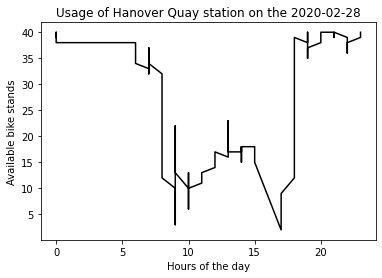

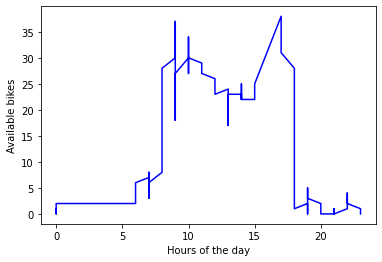

In [65]:
plt.figure()
plt.title(f'Usage of Hanover Quay station on the {Day_of_interest2}')
plt.plot(time_h2, stands_h2, 'k')
plt.xlabel('Hours of the day')
plt.ylabel('Available bike stands')
plt.title(f'Usage of Hanover Quay station on the {Day_of_interest2}')

plt.figure()
plt.plot(time_h2, bikes_h2, 'b')
plt.xlabel('Hours of the day')
plt.ylabel('Available bikes')
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

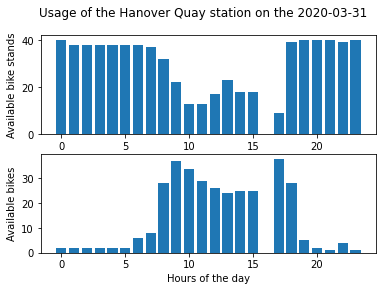

In [66]:
fig, (ax1, ax2) = plt.subplots(2)
fig.suptitle(f'Usage of the Hanover Quay station on the {Day_of_interest2}')
ax1.bar(time_h2, stands_h2)
ax1.set_xlabel('Hours of the day')
ax1.set_ylabel('Available bike stands')
ax2.bar(time_h2, bikes_h2)
ax2.set_xlabel('Hours of the day')
ax2.set_ylabel('Available bikes')
plt.show

### Usage graphs for Fitzwilliam Square East. (28/2 and 31/3)

'FITZWILLIAM SQUARE EAST' in south Dublin

In [67]:
mask_fitzwilliam = data.NAME == "FITZWILLIAM SQUARE EAST"
fitzwilliam_data = data[mask_fitzwilliam]
fitzwilliam_data

,STATION ID,LAST UPDATED,NAME,BIKE STANDS,AVAILABLE BIKE STANDS,AVAILABLE BIKES,STATUS,ADDRESS,LATITUDE,LONGITUDE,...,date_for_merge,OCCUPANCY_PCT,FULL,EMPTY,DAY_NUMBER,DAY_TYPE,TIME_TYPE,HOUR,MONTH,CLUSTER_GROUP
24481,89,00:03:24,FITZWILLIAM SQUARE EAST,40,32,8,Open,Fitzwilliam Square East,53.335213,-6.2509,...,2019-07-01 00:00:00,0.2,0,0,0,Weekday,Overnight,0,7,Overnight Weekday
24483,89,00:13:33,FITZWILLIAM SQUARE EAST,40,32,8,Open,Fitzwilliam Square East,53.335213,-6.2509,...,2019-07-01 00:00:00,0.2,0,0,0,Weekday,Overnight,0,7,Overnight Weekday
24485,89,00:23:42,FITZWILLIAM SQUARE EAST,40,32,8,Open,Fitzwilliam Square East,53.335213,-6.2509,...,2019-07-01 00:00:00,0.2,0,0,0,Weekday,Overnight,0,7,Overnight Weekday
24487,89,00:33:52,FITZWILLIAM SQUARE EAST,40,32,8,Open,Fitzwilliam Square East,53.335213,-6.2509,...,2019-07-01 01:00:00,0.2,0,0,0,Weekday,Overnight,0,7,Overnight Weekday
24489,89,00:44:01,FITZWILLIAM SQUARE EAST,40,32,8,Open,Fitzwilliam Square East,53.335213,-6.2509,...,2019-07-01 01:00:00,0.2,0,0,0,Weekday,Overnight,0,7,Overnight Weekday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2188526,89,23:16:30,FITZWILLIAM SQUARE EAST,40,24,16,Open,Fitzwilliam Square East,53.335213,-6.2509,...,2020-03-31 23:00:00,0.4,0,0,1,Weekday,Overnight,23,3,Overnight Weekday
2188528,89,23:26:38,FITZWILLIAM SQUARE EAST,40,24,16,Open,Fitzwilliam Square East,53.335213,-6.2509,...,2020-03-31 23:00:00,0.4,0,0,1,Weekday,Overnight,23,3,Overnight Weekday
2188529,89,23:32:17,FITZWILLIAM SQUARE EAST,40,24,16,Open,Fitzwilliam Square East,53.335213,-6.2509,...,2020-04-01 00:00:00,0.4,0,0,1,Weekday,Overnight,23,3,Overnight Weekday
2188531,89,23:42:26,FITZWILLIAM SQUARE EAST,40,24,16,Open,Fitzwilliam Square East,53.335213,-6.2509,...,2020-04-01 00:00:00,0.4,0,0,1,Weekday,Overnight,23,3,Overnight Weekday


In [68]:
fitzwilliam_dates = pd.to_datetime(fitzwilliam_data.date_for_merge, format = "%Y-%m-%d %H:%M:%S")

In [69]:
print(fitzwilliam_dates)

24481     2019-07-01 00:00:00
24483     2019-07-01 00:00:00
24485     2019-07-01 00:00:00
24487     2019-07-01 01:00:00
24489     2019-07-01 01:00:00
                  ...        
2188526   2020-03-31 23:00:00
2188528   2020-03-31 23:00:00
2188529   2020-04-01 00:00:00
2188531   2020-04-01 00:00:00
2188533   2020-04-01 00:00:00
Name: date_for_merge, Length: 34839, dtype: datetime64[ns]


In [70]:
fitzwilliam_dates.dt.date

24481      2019-07-01
24483      2019-07-01
24485      2019-07-01
24487      2019-07-01
24489      2019-07-01
              ...    
2188526    2020-03-31
2188528    2020-03-31
2188529    2020-04-01
2188531    2020-04-01
2188533    2020-04-01
Name: date_for_merge, Length: 34839, dtype: object

In [71]:
date_vector_f = pd.DatetimeIndex(fitzwilliam_dates.dt.date)
print(date_vector_f)

DatetimeIndex(['2019-07-01', '2019-07-01', '2019-07-01', '2019-07-01',
               '2019-07-01', '2019-07-01', '2019-07-01', '2019-07-01',
               '2019-07-01', '2019-07-01',
               ...
               '2020-03-31', '2020-03-31', '2020-03-31', '2020-03-31',
               '2020-03-31', '2020-03-31', '2020-03-31', '2020-04-01',
               '2020-04-01', '2020-04-01'],
              dtype='datetime64[ns]', name='date_for_merge', length=34839, freq=None)


In [72]:
Day_of_interest1 = '2020-03-31'
Day_index_f1 = date_vector_f == Day_of_interest1
print(Day_of_interest1)

2020-03-31


In [73]:
fitzwilliam_data[Day_index_f1]

,STATION ID,LAST UPDATED,NAME,BIKE STANDS,AVAILABLE BIKE STANDS,AVAILABLE BIKES,STATUS,ADDRESS,LATITUDE,LONGITUDE,...,date_for_merge,OCCUPANCY_PCT,FULL,EMPTY,DAY_NUMBER,DAY_TYPE,TIME_TYPE,HOUR,MONTH,CLUSTER_GROUP
2156849,89,23:33:01,FITZWILLIAM SQUARE EAST,40,25,15,Open,Fitzwilliam Square East,53.335213,-6.2509,...,2020-03-31 00:00:00,0.375,0,0,0,Weekday,Overnight,23,3,Overnight Weekday
2156851,89,23:43:11,FITZWILLIAM SQUARE EAST,40,25,15,Open,Fitzwilliam Square East,53.335213,-6.2509,...,2020-03-31 00:00:00,0.375,0,0,0,Weekday,Overnight,23,3,Overnight Weekday
2156853,89,23:53:20,FITZWILLIAM SQUARE EAST,40,25,15,Open,Fitzwilliam Square East,53.335213,-6.2509,...,2020-03-31 00:00:00,0.375,0,0,0,Weekday,Overnight,23,3,Overnight Weekday
2188248,89,00:04:35,FITZWILLIAM SQUARE EAST,40,25,15,Open,Fitzwilliam Square East,53.335213,-6.2509,...,2020-03-31 00:00:00,0.375,0,0,1,Weekday,Overnight,0,3,Overnight Weekday
2188250,89,00:15:03,FITZWILLIAM SQUARE EAST,40,25,15,Open,Fitzwilliam Square East,53.335213,-6.2509,...,2020-03-31 00:00:00,0.375,0,0,1,Weekday,Overnight,0,3,Overnight Weekday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2188520,89,22:46:04,FITZWILLIAM SQUARE EAST,40,24,16,Open,Fitzwilliam Square East,53.335213,-6.2509,...,2020-03-31 23:00:00,0.400,0,0,1,Weekday,8PM-11PM,22,3,8PM-11PM Weekday
2188522,89,22:56:12,FITZWILLIAM SQUARE EAST,40,24,16,Open,Fitzwilliam Square East,53.335213,-6.2509,...,2020-03-31 23:00:00,0.400,0,0,1,Weekday,8PM-11PM,22,3,8PM-11PM Weekday
2188524,89,23:06:21,FITZWILLIAM SQUARE EAST,40,24,16,Open,Fitzwilliam Square East,53.335213,-6.2509,...,2020-03-31 23:00:00,0.400,0,0,1,Weekday,Overnight,23,3,Overnight Weekday
2188526,89,23:16:30,FITZWILLIAM SQUARE EAST,40,24,16,Open,Fitzwilliam Square East,53.335213,-6.2509,...,2020-03-31 23:00:00,0.400,0,0,1,Weekday,Overnight,23,3,Overnight Weekday


In [74]:
fitzwilliam_day_of_interest1 = fitzwilliam_dates[Day_index_f1]
time_f1 = fitzwilliam_day_of_interest1.dt.hour
stands_f1 = fitzwilliam_data[Day_index_f1]['AVAILABLE BIKE STANDS']
bikes_f1 = fitzwilliam_data[Day_index_f1]['AVAILABLE BIKES']
bikes_f1

2156849    15
2156851    15
2156853    15
2188248    15
2188250    15
           ..
2188520    16
2188522    16
2188524    16
2188526    16
2188528    16
Name: AVAILABLE BIKES, Length: 148, dtype: int64

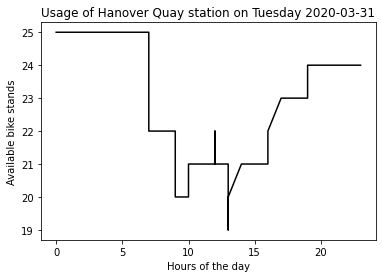

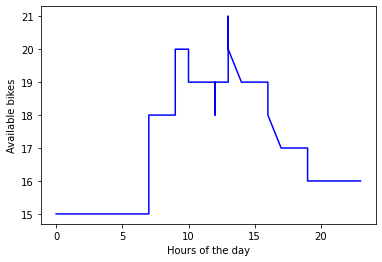

In [77]:
plt.figure()
plt.title(f'Usage of Fitzwilliam Square (East) station on Tuesday {Day_of_interest1}')
plt.plot(time_f1, stands_f1, 'k')
plt.xlabel('Hours of the day')
plt.ylabel('Available bike stands')
plt.title(f'Usage of Hanover Quay station on Tuesday {Day_of_interest1}')

plt.figure()
plt.plot(time_f1, bikes_f1, 'b')
plt.xlabel('Hours of the day')
plt.ylabel('Available bikes')
plt.show()

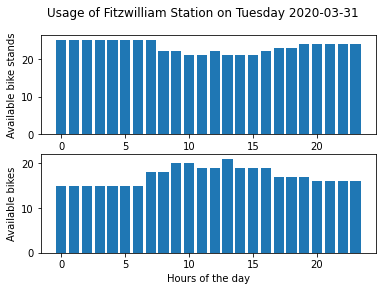

In [78]:
fig, (ax1, ax2) = plt.subplots(2)
fig.suptitle(f'Usage of Fitzwilliam Station on Tuesday {Day_of_interest1}')
ax1.bar(time_f1, stands_f1)
ax1.set_xlabel('Hours of the day')
ax1.set_ylabel('Available bike stands')
ax2.bar(time_f1, bikes_f1)
ax2.set_xlabel('Hours of the day')
ax2.set_ylabel('Available bikes')
plt.show()

Let's try for another day, before the lockdown order. 28 February, the day before the first case in Ireland.

In [79]:
Day_of_interest2 = '2020-02-28'
Day_index_f2 = date_vector_f == Day_of_interest2
print(Day_of_interest2)

2020-02-28


In [80]:
fitzwilliam_data[Day_index_f2]

,STATION ID,LAST UPDATED,NAME,BIKE STANDS,AVAILABLE BIKE STANDS,AVAILABLE BIKES,STATUS,ADDRESS,LATITUDE,LONGITUDE,...,date_for_merge,OCCUPANCY_PCT,FULL,EMPTY,DAY_NUMBER,DAY_TYPE,TIME_TYPE,HOUR,MONTH,CLUSTER_GROUP
1160065,89,23:32:14,FITZWILLIAM SQUARE EAST,40,40,0,Open,Fitzwilliam Square East,53.335213,-6.2509,...,2020-02-28 00:00:00,0.000,1,0,3,Weekday,Overnight,23,2,Overnight Weekday
1160067,89,23:42:23,FITZWILLIAM SQUARE EAST,40,40,0,Open,Fitzwilliam Square East,53.335213,-6.2509,...,2020-02-28 00:00:00,0.000,1,0,3,Weekday,Overnight,23,2,Overnight Weekday
1160069,89,23:52:33,FITZWILLIAM SQUARE EAST,40,40,0,Open,Fitzwilliam Square East,53.335213,-6.2509,...,2020-02-28 00:00:00,0.000,1,0,3,Weekday,Overnight,23,2,Overnight Weekday
1191317,89,00:02:42,FITZWILLIAM SQUARE EAST,40,40,0,Open,Fitzwilliam Square East,53.335213,-6.2509,...,2020-02-28 00:00:00,0.000,1,0,4,Weekday,Overnight,0,2,Overnight Weekday
1191319,89,00:12:51,FITZWILLIAM SQUARE EAST,40,40,0,Open,Fitzwilliam Square East,53.335213,-6.2509,...,2020-02-28 00:00:00,0.000,1,0,4,Weekday,Overnight,0,2,Overnight Weekday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1191590,89,22:48:30,FITZWILLIAM SQUARE EAST,40,39,1,Open,Fitzwilliam Square East,53.335213,-6.2509,...,2020-02-28 23:00:00,0.025,0,0,4,Weekday,8PM-11PM,22,2,8PM-11PM Weekday
1191592,89,22:58:39,FITZWILLIAM SQUARE EAST,40,39,1,Open,Fitzwilliam Square East,53.335213,-6.2509,...,2020-02-28 23:00:00,0.025,0,0,4,Weekday,8PM-11PM,22,2,8PM-11PM Weekday
1191594,89,23:08:48,FITZWILLIAM SQUARE EAST,40,39,1,Open,Fitzwilliam Square East,53.335213,-6.2509,...,2020-02-28 23:00:00,0.025,0,0,4,Weekday,Overnight,23,2,Overnight Weekday
1191596,89,23:18:57,FITZWILLIAM SQUARE EAST,40,39,1,Open,Fitzwilliam Square East,53.335213,-6.2509,...,2020-02-28 23:00:00,0.025,0,0,4,Weekday,Overnight,23,2,Overnight Weekday


In [82]:
fitzwilliam_day_of_interest2= fitzwilliam_dates[Day_index_f2]
time_f2 = fitzwilliam_day_of_interest2.dt.hour
stands_f2 = fitzwilliam_data[Day_index_f2]['AVAILABLE BIKE STANDS']
bikes_f2 = fitzwilliam_data[Day_index_f2]['AVAILABLE BIKES']
bikes_f2

1160065    0
1160067    0
1160069    0
1191317    0
1191319    0
          ..
1191590    1
1191592    1
1191594    1
1191596    1
1191598    1
Name: AVAILABLE BIKES, Length: 165, dtype: int64

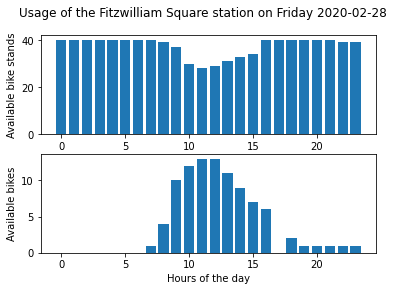

In [84]:
fig, (ax1, ax2) = plt.subplots(2)
fig.suptitle(f'Usage of the Fitzwilliam Square station on Friday {Day_of_interest2}')
ax1.bar(time_f2, stands_f2)
ax1.set_xlabel('Hours of the day')
ax1.set_ylabel('Available bike stands')
ax2.bar(time_f2, bikes_f2)
ax2.set_xlabel('Hours of the day')
ax2.set_ylabel('Available bikes')
plt.show()

### 2. Usage graphs for St. James' Hospital (Luas). (28/2 and 31/3)

'ST JAMES HOSPITAL (LUAS)'- south Dublin residential area

In [85]:
mask_james = data.NAME == 'ST JAMES HOSPITAL (LUAS)'
james_data = data[mask_james]
james_data

,STATION ID,LAST UPDATED,NAME,BIKE STANDS,AVAILABLE BIKE STANDS,AVAILABLE BIKES,STATUS,ADDRESS,LATITUDE,LONGITUDE,...,date_for_merge,OCCUPANCY_PCT,FULL,EMPTY,DAY_NUMBER,DAY_TYPE,TIME_TYPE,HOUR,MONTH,CLUSTER_GROUP
21889,80,00:03:12,ST JAMES HOSPITAL (LUAS),40,36,4,Open,St James Hospital (Luas),53.341358,-6.292951,...,2019-07-01 00:00:00,0.1,0,0,0,Weekday,Overnight,0,7,Overnight Weekday
21891,80,00:13:21,ST JAMES HOSPITAL (LUAS),40,36,4,Open,St James Hospital (Luas),53.341358,-6.292951,...,2019-07-01 00:00:00,0.1,0,0,0,Weekday,Overnight,0,7,Overnight Weekday
21893,80,00:23:31,ST JAMES HOSPITAL (LUAS),40,36,4,Open,St James Hospital (Luas),53.341358,-6.292951,...,2019-07-01 00:00:00,0.1,0,0,0,Weekday,Overnight,0,7,Overnight Weekday
21895,80,00:33:40,ST JAMES HOSPITAL (LUAS),40,36,4,Open,St James Hospital (Luas),53.341358,-6.292951,...,2019-07-01 01:00:00,0.1,0,0,0,Weekday,Overnight,0,7,Overnight Weekday
21897,80,00:43:49,ST JAMES HOSPITAL (LUAS),40,36,4,Open,St James Hospital (Luas),53.341358,-6.292951,...,2019-07-01 01:00:00,0.1,0,0,0,Weekday,Overnight,0,7,Overnight Weekday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2185934,80,23:17:50,ST JAMES HOSPITAL (LUAS),40,32,8,Open,St James Hospital (Luas),53.341358,-6.292951,...,2020-03-31 23:00:00,0.2,0,0,1,Weekday,Overnight,23,3,Overnight Weekday
2185936,80,23:27:59,ST JAMES HOSPITAL (LUAS),40,32,8,Open,St James Hospital (Luas),53.341358,-6.292951,...,2020-03-31 23:00:00,0.2,0,0,1,Weekday,Overnight,23,3,Overnight Weekday
2185937,80,23:32:06,ST JAMES HOSPITAL (LUAS),40,32,8,Open,St James Hospital (Luas),53.341358,-6.292951,...,2020-04-01 00:00:00,0.2,0,0,1,Weekday,Overnight,23,3,Overnight Weekday
2185939,80,23:42:16,ST JAMES HOSPITAL (LUAS),40,32,8,Open,St James Hospital (Luas),53.341358,-6.292951,...,2020-04-01 00:00:00,0.2,0,0,1,Weekday,Overnight,23,3,Overnight Weekday


In [86]:
james_dates = pd.to_datetime(james_data.date_for_merge, format = '%Y-%m-%d %H:%M:%S')

In [87]:
print(james_dates)

21889     2019-07-01 00:00:00
21891     2019-07-01 00:00:00
21893     2019-07-01 00:00:00
21895     2019-07-01 01:00:00
21897     2019-07-01 01:00:00
                  ...        
2185934   2020-03-31 23:00:00
2185936   2020-03-31 23:00:00
2185937   2020-04-01 00:00:00
2185939   2020-04-01 00:00:00
2185941   2020-04-01 00:00:00
Name: date_for_merge, Length: 36855, dtype: datetime64[ns]


In [88]:
james_dates.dt.date

21889      2019-07-01
21891      2019-07-01
21893      2019-07-01
21895      2019-07-01
21897      2019-07-01
              ...    
2185934    2020-03-31
2185936    2020-03-31
2185937    2020-04-01
2185939    2020-04-01
2185941    2020-04-01
Name: date_for_merge, Length: 36855, dtype: object

In [89]:
date_vector_j = pd.DatetimeIndex(james_dates.dt.date)
print(date_vector_j)

DatetimeIndex(['2019-07-01', '2019-07-01', '2019-07-01', '2019-07-01',
               '2019-07-01', '2019-07-01', '2019-07-01', '2019-07-01',
               '2019-07-01', '2019-07-01',
               ...
               '2020-03-31', '2020-03-31', '2020-03-31', '2020-03-31',
               '2020-03-31', '2020-03-31', '2020-03-31', '2020-04-01',
               '2020-04-01', '2020-04-01'],
              dtype='datetime64[ns]', name='date_for_merge', length=36855, freq=None)


In [90]:
Day_of_interest1 = '2020-03-31'
Day_index_j1 = date_vector_j == Day_of_interest1
print(Day_of_interest1)

2020-03-31


In [91]:
james_data[Day_index_j1]

,STATION ID,LAST UPDATED,NAME,BIKE STANDS,AVAILABLE BIKE STANDS,AVAILABLE BIKES,STATUS,ADDRESS,LATITUDE,LONGITUDE,...,date_for_merge,OCCUPANCY_PCT,FULL,EMPTY,DAY_NUMBER,DAY_TYPE,TIME_TYPE,HOUR,MONTH,CLUSTER_GROUP
2154257,80,23:32:31,ST JAMES HOSPITAL (LUAS),40,32,8,Open,St James Hospital (Luas),53.341358,-6.292951,...,2020-03-31 00:00:00,0.2,0,0,0,Weekday,Overnight,23,3,Overnight Weekday
2154259,80,23:42:40,ST JAMES HOSPITAL (LUAS),40,32,8,Open,St James Hospital (Luas),53.341358,-6.292951,...,2020-03-31 00:00:00,0.2,0,0,0,Weekday,Overnight,23,3,Overnight Weekday
2154261,80,23:52:48,ST JAMES HOSPITAL (LUAS),40,32,8,Open,St James Hospital (Luas),53.341358,-6.292951,...,2020-03-31 00:00:00,0.2,0,0,0,Weekday,Overnight,23,3,Overnight Weekday
2185655,80,00:03:57,ST JAMES HOSPITAL (LUAS),40,32,8,Open,St James Hospital (Luas),53.341358,-6.292951,...,2020-03-31 00:00:00,0.2,0,0,1,Weekday,Overnight,0,3,Overnight Weekday
2185658,80,00:15:10,ST JAMES HOSPITAL (LUAS),40,32,8,Open,St James Hospital (Luas),53.341358,-6.292951,...,2020-03-31 00:00:00,0.2,0,0,1,Weekday,Overnight,0,3,Overnight Weekday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2185928,80,22:47:22,ST JAMES HOSPITAL (LUAS),40,32,8,Open,St James Hospital (Luas),53.341358,-6.292951,...,2020-03-31 23:00:00,0.2,0,0,1,Weekday,8PM-11PM,22,3,8PM-11PM Weekday
2185930,80,22:57:31,ST JAMES HOSPITAL (LUAS),40,32,8,Open,St James Hospital (Luas),53.341358,-6.292951,...,2020-03-31 23:00:00,0.2,0,0,1,Weekday,8PM-11PM,22,3,8PM-11PM Weekday
2185932,80,23:07:41,ST JAMES HOSPITAL (LUAS),40,32,8,Open,St James Hospital (Luas),53.341358,-6.292951,...,2020-03-31 23:00:00,0.2,0,0,1,Weekday,Overnight,23,3,Overnight Weekday
2185934,80,23:17:50,ST JAMES HOSPITAL (LUAS),40,32,8,Open,St James Hospital (Luas),53.341358,-6.292951,...,2020-03-31 23:00:00,0.2,0,0,1,Weekday,Overnight,23,3,Overnight Weekday


In [92]:
Day_of_interest_j1 = james_dates[Day_index_j1]
time_j1 = Day_of_interest_j1.dt.hour
stands_j1 = james_data[Day_index_j1]['AVAILABLE BIKE STANDS']
bikes_j1 = james_data[Day_index_j1]['AVAILABLE BIKES']
bikes_j1

2154257    8
2154259    8
2154261    8
2185655    8
2185658    8
          ..
2185928    8
2185930    8
2185932    8
2185934    8
2185936    8
Name: AVAILABLE BIKES, Length: 155, dtype: int64

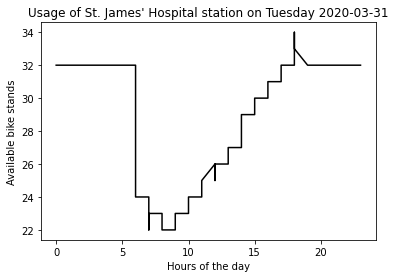

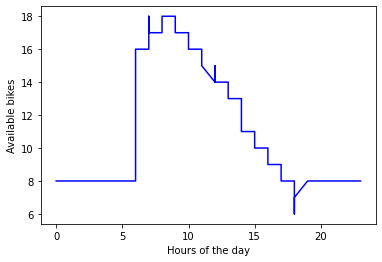

In [93]:
plt.figure()
plt.title(f"Usage of St. James' Hospital station on Tuesday {Day_of_interest1}")
plt.plot(time_j1, stands_j1, 'k')
plt.xlabel('Hours of the day')
plt.ylabel('Available bike stands')

plt.figure()
plt.plot(time_j1, bikes_j1, 'b')
plt.xlabel('Hours of the day')
plt.ylabel('Available bikes')
plt.show()

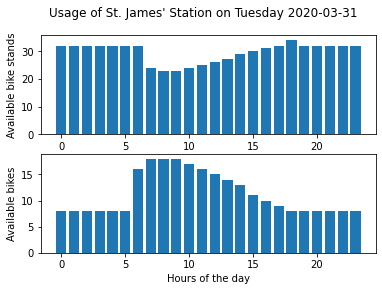

In [96]:
fig, (ax1, ax2) = plt.subplots(2)
fig.suptitle(f"Usage of St. James' Station on Tuesday {Day_of_interest1}")
ax1.bar(time_j1, stands_j1)
ax1.set_xlabel('Hours of the day')
ax1.set_ylabel('Available bike stands')
ax2.bar(time_j1, bikes_j1)
ax2.set_xlabel('Hours of the day')
ax2.set_ylabel('Available bikes')
plt.show()

Let's try for another day, before the lockdown order. 28 February, the day before the first case in Ireland.

In [97]:
Day_of_interest2 = '2020-02-28'
Day_index_j2 = date_vector_j == Day_of_interest2
print(Day_of_interest2)

2020-02-28


In [98]:
james_data[Day_index_j2]

,STATION ID,LAST UPDATED,NAME,BIKE STANDS,AVAILABLE BIKE STANDS,AVAILABLE BIKES,STATUS,ADDRESS,LATITUDE,LONGITUDE,...,date_for_merge,OCCUPANCY_PCT,FULL,EMPTY,DAY_NUMBER,DAY_TYPE,TIME_TYPE,HOUR,MONTH,CLUSTER_GROUP
1157474,80,23:36:19,ST JAMES HOSPITAL (LUAS),40,27,13,Open,St James Hospital (Luas),53.341358,-6.292951,...,2020-02-28 00:00:00,0.325,0,0,3,Weekday,Overnight,23,2,Overnight Weekday
1157476,80,23:46:28,ST JAMES HOSPITAL (LUAS),40,27,13,Open,St James Hospital (Luas),53.341358,-6.292951,...,2020-02-28 00:00:00,0.325,0,0,3,Weekday,Overnight,23,2,Overnight Weekday
1188724,80,23:56:38,ST JAMES HOSPITAL (LUAS),40,27,13,Open,St James Hospital (Luas),53.341358,-6.292951,...,2020-02-28 00:00:00,0.325,0,0,3,Weekday,Overnight,23,2,Overnight Weekday
1188726,80,00:06:47,ST JAMES HOSPITAL (LUAS),40,27,13,Open,St James Hospital (Luas),53.341358,-6.292951,...,2020-02-28 00:00:00,0.325,0,0,4,Weekday,Overnight,0,2,Overnight Weekday
1188728,80,00:16:56,ST JAMES HOSPITAL (LUAS),40,27,13,Open,St James Hospital (Luas),53.341358,-6.292951,...,2020-02-28 00:00:00,0.325,0,0,4,Weekday,Overnight,0,2,Overnight Weekday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1188997,80,22:41:09,ST JAMES HOSPITAL (LUAS),40,21,19,Open,St James Hospital (Luas),53.341358,-6.292951,...,2020-02-28 23:00:00,0.475,0,0,4,Weekday,8PM-11PM,22,2,8PM-11PM Weekday
1188999,80,22:51:18,ST JAMES HOSPITAL (LUAS),40,21,19,Open,St James Hospital (Luas),53.341358,-6.292951,...,2020-02-28 23:00:00,0.475,0,0,4,Weekday,8PM-11PM,22,2,8PM-11PM Weekday
1189001,80,23:00:54,ST JAMES HOSPITAL (LUAS),40,22,18,Open,St James Hospital (Luas),53.341358,-6.292951,...,2020-02-28 23:00:00,0.450,0,0,4,Weekday,Overnight,23,2,Overnight Weekday
1189003,80,23:11:03,ST JAMES HOSPITAL (LUAS),40,22,18,Open,St James Hospital (Luas),53.341358,-6.292951,...,2020-02-28 23:00:00,0.450,0,0,4,Weekday,Overnight,23,2,Overnight Weekday


In [100]:
james_day_of_interest2 = james_dates[Day_index_j2]
time_j2 = james_day_of_interest2.dt.hour
stands_j2 = james_data[Day_index_j2]['AVAILABLE BIKE STANDS']
bikes_j2 = james_data[Day_index_j2]['AVAILABLE BIKES']
bikes_j2

1157474    13
1157476    13
1188724    13
1188726    13
1188728    13
           ..
1188997    19
1188999    19
1189001    18
1189003    18
1189005    19
Name: AVAILABLE BIKES, Length: 178, dtype: int64

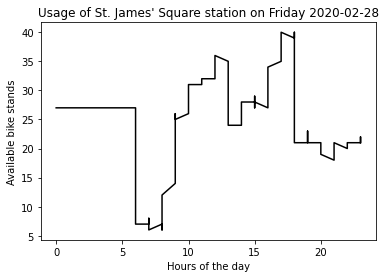

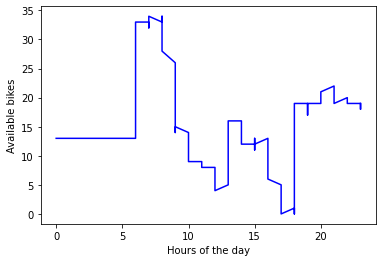

In [102]:
plt.figure()
plt.title(f"Usage of St. James' Square station on Friday {Day_of_interest2}")
plt.plot(time_j2, stands_j2, 'k')
plt.xlabel('Hours of the day')
plt.ylabel('Available bike stands')

plt.figure()
plt.plot(time_j2, bikes_j2, 'b')
plt.xlabel('Hours of the day')
plt.ylabel('Available bikes')
plt.show()

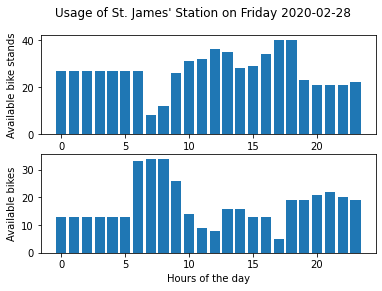

In [103]:
fig, (ax1, ax2) = plt.subplots(2)
fig.suptitle(f"Usage of St. James' Station on Friday {Day_of_interest2}")
ax1.bar(time_j2, stands_j2)
ax1.set_xlabel('Hours of the day')
ax1.set_ylabel('Available bike stands')
ax2.bar(time_j2, bikes_j2)
ax2.set_xlabel('Hours of the day')
ax2.set_ylabel('Available bikes')
plt.show()